In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import os
import re
import json
import time

import random
import numpy as np
from jiwer import wer
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder

from IPython.display import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 42

## Common parameters

In [2]:
batch_size = 32
split_ratio = 0.8
learning_rate = 0.001

device = "cuda"

# Loading bAbi

In [4]:
from babi import babiDataset

task = 2

babi = babiDataset(task=task, split_ratio=split_ratio, device=device)
babi.load(verbose=True)
train_loader, valid_loader, test_loader = babi.create_data_loader(batch_size)

Training data size:    8000
Validation data size:  2000
Test data size:        1000


# LSTM

In [5]:
# Input dim
input_dim = babi.max_vocab_size
# Number of hidden nodes
hidden_dim = 256
# Number of output nodes
output_dim = babi.max_vocab_size
# Number of LSTMs cells to be stacked
layers = 1
# Boolean value for bidirectioanl or not
bidirectional = True
# Boolean value to use LayerNorm or not
layernorm = False

### Our implementation

In [6]:
from seq_seq_same import LSTMSeq2SeqSame

our = LSTMSeq2SeqSame(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                        layers=layers, bidirectional=bidirectional).to(device)

print("Our implementation\n{}".format("=" * len("Our implementation")))
print("# of parameters: {}".format(our.count_parameters()))
for name, param in our.named_parameters():
    print("{:<25}: {}".format(name, param.shape))

Our implementation
# of parameters: 618532
lstm.model.0.weights     : torch.Size([292, 1024])
lstm.model.0.bias        : torch.Size([1024])
lstm.model_rev.0.weights : torch.Size([292, 1024])
lstm.model_rev.0.bias    : torch.Size([1024])
fc.weight                : torch.Size([36, 512])
fc.bias                  : torch.Size([36])


In [7]:
from seq_seq_same import Seq2SeqSame

loss_fn = nn.CrossEntropyLoss()
optimizer_our = torch.optim.Adam(our.parameters(), lr=learning_rate)

task_our = Seq2SeqSame(our, optimizer_our, loss_fn, device)

Beginning training model with 160278 parameters
Files will be saved in: dump/Seq2SeqSame/Our/

Epoch #1: Batch 250/250 -- Loss = 0.1086023822426796; Time taken: 0.19549012184143066ss
Epoch #1: Average loss is 0.3593522633612156
Epoch #1: Train WER is 1.0
Epoch #1: Validation WER is 1.0
Time taken for epoch: 73.30066204071045s

Epoch #2: Batch 250/250 -- Loss = 0.05617695674300194; Time taken: 0.19971561431884766ss
Epoch #2: Average loss is 0.0696959458887577
Time taken for epoch: 50.24725270271301s

Epoch #3: Batch 250/250 -- Loss = 0.06047941371798515; Time taken: 0.2024221420288086s3s
Epoch #3: Average loss is 0.06192107139527798
Time taken for epoch: 50.09034013748169s

Epoch #4: Batch 250/250 -- Loss = 0.059934236109256744; Time taken: 0.1997971534729004ss
Epoch #4: Average loss is 0.05750268976390362
Time taken for epoch: 50.126322984695435s

Epoch #5: Batch 250/250 -- Loss = 0.04725957289338112; Time taken: 0.1984419822692871sss
Epoch #5: Average loss is 0.0516423022300005
Epoch 

Epoch #42: Batch 250/250 -- Loss = 0.020231936126947403; Time taken: 0.20758914947509766s
Epoch #42: Average loss is 0.020300116766244172
Time taken for epoch: 48.92496681213379s

Epoch #43: Batch 250/250 -- Loss = 0.020987384021282196; Time taken: 0.19148731231689453s
Epoch #43: Average loss is 0.019407514728605746
Time taken for epoch: 48.63900923728943s

Epoch #44: Batch 250/250 -- Loss = 0.01509177777916193; Time taken: 0.19069457054138184ss
Epoch #44: Average loss is 0.018596263691782952
Time taken for epoch: 48.71963357925415s

Epoch #45: Batch 250/250 -- Loss = 0.020036883652210236; Time taken: 0.1917400360107422ss
Epoch #45: Average loss is 0.0177453074157238
Epoch #45: Train WER is 0.19383003492433062
Epoch #45: Validation WER is 0.2710154673839946
Time taken for epoch: 68.7478563785553s

Epoch #46: Batch 250/250 -- Loss = 0.018564216792583466; Time taken: 0.19411659240722656s
Epoch #46: Average loss is 0.016774785831570625
Time taken for epoch: 49.30863690376282s

Epoch #47: 

Epoch #124: Batch 250/250 -- Loss = 0.0005848482251167297; Time taken: 0.20831918716430664ss
Epoch #124: Average loss is 0.0004768685287272092
Time taken for epoch: 51.19286775588989s

Epoch #125: Batch 250/250 -- Loss = 0.0001711052900645882; Time taken: 0.19844317436218262ss
Epoch #125: Average loss is 0.0005030612124537583
Epoch #125: Train WER is 0.0012057209379677367
Epoch #125: Validation WER is 0.053967720242098186
Time taken for epoch: 71.8257737159729s

Epoch #126: Batch 250/250 -- Loss = 0.0008477445226162672; Time taken: 0.20595979690551758ss
Epoch #126: Average loss is 0.0010597734009497799
Time taken for epoch: 49.753239154815674s

Epoch #127: Batch 250/250 -- Loss = 0.0017286117654293776; Time taken: 0.1973578929901123ss
Epoch #127: Average loss is 0.0028897357288515195
Time taken for epoch: 50.0340850353241s

Epoch #128: Batch 250/250 -- Loss = 0.0024970388039946556; Time taken: 0.19695663452148438s
Epoch #128: Average loss is 0.002274535429896787
Time taken for epoch: 4

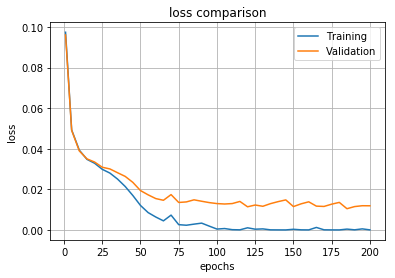

In [19]:
our, our_stats = task_our.train(epochs=200, train_loader=train_loader, valid_loader=valid_loader, 
                                out_dir='dump/Seq2SeqSame/Our/', freq=5, vocab=babi.vocab, 
                                wer_dict=babi.wer_dict)

In [20]:
our_wer, _ = task_our.evaluate(test_loader, babi.vocab, babi.wer_dict, verbose=True)
print(our_wer)

Confusion Matrix: 
 [[304  35  55  17  35  15]
 [ 52 278  29  28  29  25]
 [ 46  27 405  37  53  39]
 [ 59  49  31 311  42  35]
 [ 47  34  44  32 303  37]
 [ 38  24  17  36  16 336]]

Classification Report: 
               precision    recall  f1-score   support

           7       0.56      0.66      0.60       461
          10       0.62      0.63      0.63       441
          16       0.70      0.67      0.68       607
          17       0.67      0.59      0.63       527
          20       0.63      0.61      0.62       497
          21       0.69      0.72      0.70       467

   micro avg       0.65      0.65      0.65      3000
   macro avg       0.65      0.65      0.64      3000
weighted avg       0.65      0.65      0.65      3000

0.35433333333333333


In [85]:
for text, label in test_loader:
    pass
h = torch.zeros(2 * task_our.model.layers, label.shape[0], task_our.model.hidden_dim).to(device)
c = torch.zeros(2 * task_our.model.layers, label.shape[0], task_our.model.hidden_dim).to(device)
o = task_our.model(text.transpose(0, 1).to(device), h, c)
for i in range(text.shape[0]):
    s1 = ' '.join(babi.vocab[torch.argmax(text, 2)[i].numpy()])
    s1 = s1.replace('_', '\r')
    s2 = ' '.join(babi.vocab[torch.argmax(o.transpose(1,0), 2)[i].cpu().numpy()])
    s2 = s2.replace('_ _ _', '')
    s2 = s2.replace('_ _', '')
    s2 = s2.replace('_', '')
    print(s1)
    print(s2)
    print("-" * 100)

 Mary moved to the hallway . Sandra went to the garden . Where is Sandra ? Mary went back to the kitchen . Sandra journeyed to the kitchen . Where is Sandra ? Daniel went back to the garden . John went to the garden . Where is John ?
                 garden       kitchen       garden
----------------------------------------------------------------------------------------------------
 Mary moved to the hallway . Sandra went to the garden . Where is Sandra ? Mary went back to the kitchen . Sandra journeyed to the kitchen . Where is Sandra ? Daniel went back to the garden . John went to the garden . Where is John ? Mary travelled to the office . Sandra went to the bathroom . Where is Daniel ?
            garden       kitchen       garden      garden
----------------------------------------------------------------------------------------------------
 Mary moved to the hallway . Sandra went to the garden . Where is Sandra ? Mary went back to the kitchen . Sandra journeyed to the kitchen . W

In [60]:
 #.shape, text.shape

['_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_'
 '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_'
 'Mary' 'moved' 'to' 'the' 'hallway' '.' 'Sandra' 'went' 'to' 'the'
 'garden' '.' 'Where' 'is' 'Sandra' '?' 'Mary' 'went' 'back' 'to' 'the'
 'kitchen' '.' 'Sandra' 'journeyed' 'to' 'the' 'kitchen' '.' 'Where' 'is'
 'Sandra' '?' 'Daniel' 'went' 'back' 'to' 'the' 'garden' '.' 'John' 'went'
 'to' 'the' 'garden' '.' 'Where' 'is' 'John' '?']
['_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_'
 '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_'
 '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' 'garden' '_' '_'
 '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' 'kitchen' '_' '_'
 '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' 'garden']


### PyTorch implementation

In [5]:
from seq_seq_same import PyTorchBaseline

pytorch = PyTorchBaseline(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                        layers=layers, bidirectional=bidirectional).to(device)

print("Our implementation\n{}".format("=" * len("Our implementation")))
print("# of parameters: {}".format(pytorch.count_parameters()))
for name, param in pytorch.named_parameters():
    print("{:<25}: {}".format(name, param.shape))

Our implementation
# of parameters: 161302
lstm.weight_ih_l0        : torch.Size([512, 22])
lstm.weight_hh_l0        : torch.Size([512, 128])
lstm.bias_ih_l0          : torch.Size([512])
lstm.bias_hh_l0          : torch.Size([512])
lstm.weight_ih_l0_reverse: torch.Size([512, 22])
lstm.weight_hh_l0_reverse: torch.Size([512, 128])
lstm.bias_ih_l0_reverse  : torch.Size([512])
lstm.bias_hh_l0_reverse  : torch.Size([512])
fc.weight                : torch.Size([22, 256])
fc.bias                  : torch.Size([22])


In [6]:
from seq_seq_same import Seq2SeqSame

loss_fn = nn.CrossEntropyLoss()
optimizer_pytorch = torch.optim.Adam(pytorch.parameters(), lr=learning_rate)

task_pytorch = Seq2SeqSame(pytorch, optimizer_pytorch, loss_fn, device)

Beginning training model with 161302 parameters
Files will be saved in: dump/Seq2SeqSame/PyTorch/

Epoch #1: Batch 250/250 -- Loss = 0.09766252338886261; Time taken: 0.01817774772644043ss
Epoch #1: Average loss is 0.3309956705272198
Epoch #1: Train WER is 1.0
Epoch #1: Validation WER is 1.0
Time taken for epoch: 7.812786340713501s

Epoch #2: Batch 250/250 -- Loss = 0.06445416808128357; Time taken: 0.017499685287475586ss
Epoch #2: Average loss is 0.07100786229968072
Time taken for epoch: 5.115179061889648s

Epoch #3: Batch 250/250 -- Loss = 0.05718819051980972; Time taken: 0.02117466926574707s8s
Epoch #3: Average loss is 0.061803809136152264
Time taken for epoch: 5.38176417350769s

Epoch #4: Batch 250/250 -- Loss = 0.05517381802201271; Time taken: 0.01703357696533203s2s
Epoch #4: Average loss is 0.05652186757326126
Time taken for epoch: 5.35343599319458s

Epoch #5: Batch 250/250 -- Loss = 0.041883114725351334; Time taken: 0.021523475646972656s
Epoch #5: Average loss is 0.051234923228621

Epoch #42: Batch 250/250 -- Loss = 0.022698311135172844; Time taken: 0.021372556686401367s
Epoch #42: Average loss is 0.020287653382867574
Time taken for epoch: 4.657675504684448s

Epoch #43: Batch 250/250 -- Loss = 0.020856307819485664; Time taken: 0.020241498947143555s
Epoch #43: Average loss is 0.019131135825067758
Time taken for epoch: 4.691173791885376s

Epoch #44: Batch 250/250 -- Loss = 0.01909993588924408; Time taken: 0.018783092498779297ss
Epoch #44: Average loss is 0.018400690663605928
Time taken for epoch: 4.684077024459839s

Epoch #45: Batch 250/250 -- Loss = 0.01586349681019783; Time taken: 0.01599884033203125sss
Epoch #45: Average loss is 0.01729416811466217
Epoch #45: Train WER is 0.17769832030600366
Epoch #45: Validation WER is 0.27051109616677876
Time taken for epoch: 7.411954402923584s

Epoch #46: Batch 250/250 -- Loss = 0.015193642117083073; Time taken: 0.016649484634399414s
Epoch #46: Average loss is 0.01727966082468629
Time taken for epoch: 4.722104549407959s

Epoc

Epoch #123: Batch 250/250 -- Loss = 1.1179934517713264e-05; Time taken: 0.017221450805664062s
Epoch #123: Average loss is 1.4125271911325398e-05
Time taken for epoch: 4.684989929199219s

Epoch #124: Batch 250/250 -- Loss = 1.1494214049889706e-05; Time taken: 0.020652294158935547s
Epoch #124: Average loss is 1.2492074200054048e-05
Time taken for epoch: 4.671291351318359s

Epoch #125: Batch 250/250 -- Loss = 1.1783431546064094e-05; Time taken: 0.017317533493041992s
Epoch #125: Average loss is 1.104395704351191e-05
Epoch #125: Train WER is 0.0
Epoch #125: Validation WER is 0.057330195023537325
Time taken for epoch: 7.377926349639893s

Epoch #126: Batch 250/250 -- Loss = 0.019311176612973213; Time taken: 0.019614219665527344ss
Epoch #126: Average loss is 0.02927981736019683
Time taken for epoch: 4.668739318847656s

Epoch #127: Batch 250/250 -- Loss = 0.015942083671689034; Time taken: 0.016927242279052734ss
Epoch #127: Average loss is 0.01685916627384722
Time taken for epoch: 4.643506050109

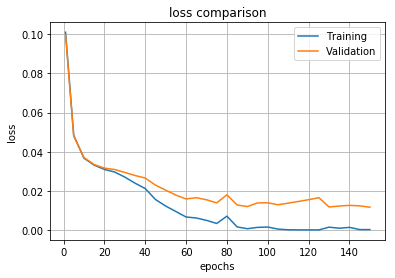

In [7]:
pytorch, pytorch_stats = task_pytorch.train(epochs=150, train_loader=train_loader, valid_loader=valid_loader, 
                                            out_dir='dump/Seq2SeqSame/PyTorch/', freq=5, vocab=babi.vocab, 
                                            wer_dict=babi.wer_dict)

In [16]:
pytorch_wer, _ = task_pytorch.evaluate(test_loader, babi.vocab, babi.wer_dict, verbose=True)
print(pytorch_wer)

Confusion Matrix: 
 [[317  21  31  21  54  17]
 [ 21 292  26  37  19  46]
 [ 48  35 419  30  33  42]
 [ 61  41  40 320  35  30]
 [ 41  28  42  37 311  38]
 [ 44  17  38  51  27 290]]

Classification Report: 
               precision    recall  f1-score   support

           7       0.60      0.69      0.64       461
          10       0.67      0.66      0.67       441
          16       0.70      0.69      0.70       607
          17       0.65      0.61      0.63       527
          20       0.65      0.63      0.64       497
          21       0.63      0.62      0.62       467

   micro avg       0.65      0.65      0.65      3000
   macro avg       0.65      0.65      0.65      3000
weighted avg       0.65      0.65      0.65      3000

0.35033333333333333


***

# TRANSFORMER